# Eta

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
def load(filename: str):
    return pd.read_csv(filename)

In [3]:
huile1_haut = load('../data/huile1_haut.csv')
huile1_bas = load('../data/huile1_bas.csv')
huile2_haut = load('../data/huile2_haut.csv')
huile2_bas = load('../data/huile2_bas.csv')

# Do the calcs

In [4]:
def sel_dist(arr: np.ndarray, dist: float) -> np.ndarray:
    idx = [0]
    for i, n in enumerate(arr[1:]):
        if abs(n - arr[idx[-1]]) > dist:
            idx.append(i+1)
    return np.array(idx)

In [5]:
def calc_eta(datas, densite):
    v_inf = distance_top_bottom / (unp.uarray(datas['Temps 2 [s]'], delta_t) - unp.uarray(datas['Temps 1 [s]'], delta_t))
    # Equilibre des forces
    # g(m - 4/3 pi r^3 densite_huile) - trainée = 0
    trainee = 6 * np.pi * bille_rayon * v_inf
    eta = g * (bille_masse - densite * 4/3 * np.pi * bille_rayon**3) / trainee
    Re = densite/eta * v_inf * bille_rayon * 2
    print(f"Re (min/max/avg): {np.min(Re):.1uP}/{np.max(Re):.1uP}/{np.mean(Re):.1uP}")
    return eta

In [6]:
def plot_and_print(datas, densite, tol=1e-8, color=None, label=None):
    eta = calc_eta(datas, densite)

    T_inv = 1/unp.uarray(datas['Temperature [C]']+273.15, delta_T)
    ln_eta = unp.log(eta)
    coefs, cov = np.polyfit(nom_vals(T_inv), nom_vals(ln_eta), 1, cov=True)
    coefs_err = unp.uarray(coefs, np.sqrt(np.diag(cov)))
    fitfunc = np.poly1d(coefs)
    # * k_boltzmann bc coef is in [J/k]
    print(f"E = {coefs_err[0]*k_boltzmann:.1uP}, A = {unp.exp(coefs_err[1]):.1uP}")

    plt.plot(nom_vals(T_inv), fitfunc(nom_vals(T_inv)), '--', alpha=0.8, color=color, label=r'Fit: $y = ({:.1uL})x + ({:.1uL})$'.format(*coefs_err))

    idx_to_plot = sel_dist(T_inv, tol)
    x = T_inv[idx_to_plot]
    y = ln_eta[idx_to_plot]
    plt.errorbar(nom_vals(x), nom_vals(y), xerr=std_devs(x), yerr=std_devs(y), ls='none', color=color, label=label)

## TOGETHER!

Re (min/max/avg): 1.6±0.2/16±6/7.6±0.8
E = (2.9±0.2)×10⁻²⁰, A = (1.5±0.5)×10⁻⁵
Re (min/max/avg): 2.3±0.4/15±6/6.5±0.6
E = (2.68±0.06)×10⁻²⁰, A = (3.1±0.4)×10⁻⁵


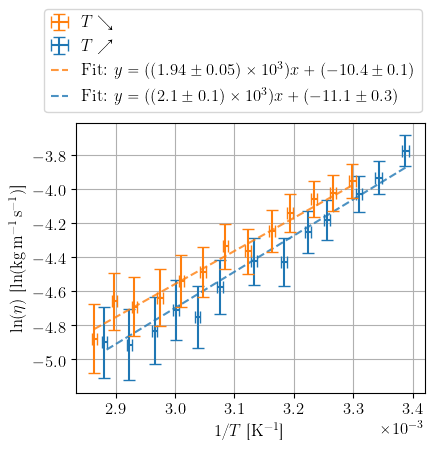

In [7]:
plot_and_print(huile1_haut, densite_1, 0.00003, label='$T\\nearrow$', color='tab:blue')
plot_and_print(huile1_bas, densite_1, 0.00003, label='$T\\searrow$', color='tab:orange')
plt.xlabel(r'$1/T$ [\si{\per\kelvin}]')
plt.ylabel(r'$\ln(\eta)$ [$\ln$(\si{\kilo\gram\per\meter\per\second})]')
plt.legend(loc='lower center', bbox_to_anchor=(0.45, 1.01), reverse=True, handlelength=1)
plt.grid()
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, -3))
plt.savefig('../figures/huile1_lneta.pdf')

Re (min/max/avg): 0.070±0.006/3.8±0.8/1.3±0.1
E = (5.4±0.1)×10⁻²⁰, A = (1.3±0.4)×10⁻⁷
Re (min/max/avg): 0.100±0.008/3.5±0.7/1.10±0.09
E = (5.35±0.09)×10⁻²⁰, A = (2.0±0.4)×10⁻⁷


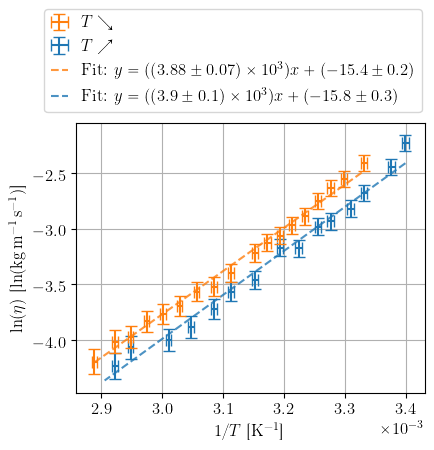

In [8]:
plot_and_print(huile2_haut, densite_2, 0.00002, label='$T\\nearrow$', color='tab:blue')
plot_and_print(huile2_bas, densite_2, 0.00002, label='$T\\searrow$', color='tab:orange')
plt.xlabel(r'$1/T$ [\si{\per\kelvin}]')
plt.ylabel(r'$\ln(\eta)$ [$\ln$(\si{\kilo\gram\per\meter\per\second})]')
plt.legend(loc='lower center', bbox_to_anchor=(0.45, 1.01), reverse=True, handlelength=1)
plt.grid()
plt.ticklabel_format(axis='x', style='sci', scilimits=(0, -3))
plt.savefig('../figures/huile2_lneta.pdf')

## Difference to reference

15

68

In [9]:
def calc_diff(datas, densite, ref):
    eta = calc_eta(datas, densite)
    T = unp.uarray(datas['Temperature [C]']+273.15, delta_T)
    idx = (np.where(np.diff(np.sign(nom_vals(T) - (40 + 273.15))) != 0)[0] + 1)[0]
    eta_cin = eta[idx] / densite * 1e6  # mm²/s
    print(f"nu = {eta_cin:.1uP}, nu_ref = {ref}, diff {abs(ref - eta_cin)/ref*100:.1uP}")

In [10]:
calc_diff(huile1_haut, densite_1, 15)
calc_diff(huile1_bas, densite_1, 15)
calc_diff(huile2_haut, densite_2, 68)
calc_diff(huile2_bas, densite_2, 68)

Re (min/max/avg): 1.6±0.2/16±6/7.6±0.8
nu = 15±2, nu_ref = 15, diff (0±1)×10¹
Re (min/max/avg): 2.3±0.4/15±6/6.5±0.6
nu = 19±2, nu_ref = 15, diff (3±1)×10¹
Re (min/max/avg): 0.070±0.006/3.8±0.8/1.3±0.1
nu = 50±4, nu_ref = 68, diff 26±6
Re (min/max/avg): 0.100±0.008/3.5±0.7/1.10±0.09
nu = 56±4, nu_ref = 68, diff 18±6
